## Objective

Below follows a comparative analysis of five pre-trained CNN's in PyTorch. ImageNet images were selected from four different categories in order to be identified from the CNN's and for transfer learning to be leveraged.

In [4]:
from PIL import Image
import glob
import requests
import json

import torch
from torchvision import models,transforms
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

The url's of the selected images were aggregated within text files and are downloaded here.

In [0]:
!wget -i elephants.txt -P 'elephants/'
!wget -i icecreams.txt -P 'icecreams/'
!wget -i dogs.txt -P 'dogs/'
!wget -i mushrooms.txt -P 'mushrooms/'
!wget -i jellyfish.txt -P 'jellyfish/'

All images are aggregated in seperate lists based on their category.

In [0]:
elephants = []

for filename in glob.glob('elephants/*'):
    im=Image.open(filename)
    elephants.append(im)

In [0]:
ice_creams = []

for filename in glob.glob('icecreams/*'):
    im=Image.open(filename)
    ice_creams.append(im)

In [0]:
mushrooms = []

for filename in glob.glob('mushrooms/*'):
    im=Image.open(filename)
    mushrooms.append(im)

In [0]:
dogs = []

for filename in glob.glob('dogs/*'):
    im=Image.open(filename)
    dogs.append(im)

In [0]:
jellyfish = []

for filename in glob.glob('jellyfish/*'):
    im=Image.open(filename)
    jellyfish.append(im)

Download of the json file that contains the mapping between the imagenet categories and their indexes.

In [0]:
labels = requests.get('https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json').json()

Preprocessing of the selected images that involves the resizing of the image and the normalization of its three channels (RGB). All pre-trained models expect input images normalized in the same way, while the height and width of each image is expected to be at least 224 (source: [PyTorch documentation](https://pytorch.org/docs/stable/torchvision/models.html))

In [0]:
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean = [0.485, 0.456, 0.406],
            std = [0.229, 0.224, 0.225])
      ])

The sequence of transforms is applied to the selected images.

In [0]:
elephant_batch = torch.stack(list(map(transform,elephants))).to('cuda')
ice_cream_batch = torch.stack(list(map(transform,ice_creams))).to('cuda')
mushroom_batch = torch.stack(list(map(transform,mushrooms))).to('cuda')
jellyfish_batch = torch.stack(list(map(transform,jellyfish))).to('cuda')
dogs_batch = torch.stack(list(map(transform,dogs))).to('cuda')

The selected pretrained models are resnet, inception, googlenet, alexnet και vgg16, while they are loaded from PyTorch with the  flag pretrained set to True. Below follows a short description of their architecture:


*   **Resnet**: The Resnet model faces the problem of the vanishing gradient in deep networks during back propagation. The Residual blocks that are inserted in this deep CNN define a pass-through function, where the output is the same as the input. In this way information already learnt by the network is propagated to the next layers. This information is added to the knowledge that is acquired by the intermediate layers and aims at the approximation of the actual data distribution by acting as the "residual" information that needs to be added to the actual output of the intermediate layers.
*  **Googlenet**: Googlenet a.k.a. Inception v1 is a CNN that contains Inception modules (multiple filters). At each layer takes place convolution with three differently sized filters (1x1, 3x3, 5x5), max pooling, while additional 1x1 convolution filters are added for dimensionlity reduction. Lastly, in the middle of the CNN are placed two auxiliary classifiers in order to balance the total loss of the network and prevent the middle section of this deep network to atrophy. 
*   **Inception**: Inception v3 is the enhanced version of the previous version Inception model, where smaller sized  convolution kernels have replaced the previous larger ones in order to cut down in computational cost. Furthermore, the representation bottleneck is addressed by the factorization of the convolution kernels into smaller sized ones, and the auxiliary classifiers are enhanced with the introduction of the BatchNorm layer and the addition of Label Smoothing in order to normazize the loss function.
*   **Alexnet**: CNN AlexNet is consisted of 8 layers, 5 convolution and 3 fully-connected, while it is constructed upon two pipelines that enable its training to be executed in parallel. The distinctive features of this network are the introduction of ReLU as a non-linear activation function, the network's training on multiple gpu's, as well as the overlapping of the neighboring neurons pooling. Lasly, this network involves data augmentation techniques for the extension of the training dataset and Dropout nodes to avoid overfitting. 
*   **Vgg16**: Vgg16 is consisted of 16 convolutional, max pooling, fully-connected and activation layers. In specific, Vgg16 includes 13 convolutional layers, 5 max-pooling, and 3 fully-connected layers that are located near the output layers of the CNN.


In [ ]:
resnet = models.resnet152(pretrained=True).to('cuda')
inception = models.inception_v3(pretrained=True).to('cuda')
googlenet = models.googlenet(pretrained=True).to('cuda')
alexnet = models.alexnet(pretrained=True).to('cuda')
vgg16 = models.vgg16(pretrained=True).to('cuda')

In [0]:
model_list = dict()

model_list['resnet'] = resnet
model_list['inception'] = inception
model_list['googlenet'] = googlenet
model_list['alexnet'] = alexnet
model_list['vgg16'] = vgg16

In [0]:
def inference(model_list, batch, labels):
    for i,model in model_list.items():
        print(i)
        model_list[i].eval() #switch models to evaluation mode
        out = model_list[i](batch)

        probs, cls_indices = torch.nn.functional.softmax(out,dim=1).topk(5) #top 5 predictions are selected
        cls_labels = list(map(lambda x: [labels[str(int(i))][-1] for i in x],cls_indices.to('cpu')))
        probs = probs.detach().cpu().numpy()*100  

        for i in range(len(cls_labels)):
            print(cls_labels[i])
            print(['%.2f' % p + '%' for p in probs[i]])


In [0]:
inference(model_list, elephant_batch, labels)

fig,axes = plt.subplots(ncols = 6, figsize=(50,50))
for i in range(6):
    axes[i].imshow(elephants[i])

resnet
['tusker', 'Indian_elephant', 'African_elephant', 'Indian_cobra', 'Arabian_camel']
['46.79%', '46.56%', '6.45%', '0.07%', '0.01%']
['tusker', 'African_elephant', 'Indian_elephant', 'hartebeest', 'triceratops']
['54.94%', '44.87%', '0.19%', '0.00%', '0.00%']
['Indian_elephant', 'tusker', 'African_elephant', 'triceratops', 'hippopotamus']
['89.31%', '9.88%', '0.71%', '0.02%', '0.02%']
['African_elephant', 'tusker', 'Indian_elephant', 'warthog', 'triceratops']
['72.40%', '23.60%', '3.38%', '0.17%', '0.05%']
['Indian_elephant', 'African_elephant', 'tusker', 'Arabian_camel', 'bison']
['40.85%', '33.02%', '25.39%', '0.29%', '0.13%']
['Indian_elephant', 'tusker', 'African_elephant', 'water_buffalo', 'ox']
['63.31%', '36.35%', '0.29%', '0.03%', '0.01%']
inception
['Indian_elephant', 'tusker', 'African_elephant', 'Arabian_camel', 'king_penguin']
['61.68%', '37.80%', '0.40%', '0.07%', '0.01%']
['African_elephant', 'tusker', 'Indian_elephant', 'combination_lock', 'ocarina']
['94.38%', '5.6

These images were selected in such a way as to contain depictions of elephants from different points of view, and with additional objects within the picture. Morevover, one image was selected in order to depict only the outline of the elephants in order to investigate whether the CNN's would identify them. 

*   Resnet: Resnet successfully recognizes all 6 photos as some species of elephant, and distributes the larger probabilities amongst these different species. The network though fails to identify the bananas in its top 5 predictions. Nevertheless, the first picture is identified as a cobra with a small probability due to the perspective from which the trunk of the elephant is depicted, and the position of the cane.
*   Inception: Inception seems to predict with high confidence the species of the depicted elephants by assigning larger probability to each top prediction.
*   GoogleNet: GoogleNet correctly identifies all pictures by assigining larger probabilities to the corresponding labels. Despite the fact that the larger cumulative possibility is assigned to elephants, this network is not characterized by high confidence. That is, it assigns significant probabilites to labels that the rest of the networks assign with much smaller probabilities. Furthermore, in the first picture the network assigns a significant percentage to the Arabian camel as the second most probable prediction. 
*   AlexNet: The irony with the Alexnet network is that despite recognizing the existence of bananas in the first photo, it fails to recognize the existence of the elephant. In the rest of the photos AlexNet predicts with high probabilities the existence of elehpants, without assigning nevertheless high probability to its top prediction in the cases that not all of an elephant's visual attributes are depicted (i.e. the third photograph is prevailed by the elephant's trunk).
*   Vgg16: This network predicts with cumulative high probability the depiction of an elephant. Likewise ResNet, the trunk of the elephant and the cane are misinterpreted as a snake with low probability. 

In [0]:
inference(model_list, ice_cream_batch, labels)

fig,axes = plt.subplots(ncols = 6, figsize=(50,50))
for i in range(6):
    axes[i].imshow(ice_creams[i])

resnet
['dough', 'face_powder', 'spatula', 'ice_cream', 'hammer']
['58.67%', '13.06%', '8.42%', '5.39%', '2.97%']
['ice_cream', 'trifle', 'eggnog', 'chocolate_sauce', 'soup_bowl']
['61.66%', '34.63%', '1.36%', '0.42%', '0.22%']
['ice_lolly', 'ice_cream', 'chocolate_sauce', 'spatula', 'matchstick']
['99.97%', '0.01%', '0.01%', '0.01%', '0.00%']
['ice_cream', 'chocolate_sauce', 'stinkhorn', 'cock', 'bakery']
['94.12%', '1.65%', '1.32%', '0.60%', '0.48%']
['ice_cream', 'chocolate_sauce', 'trifle', 'cup', 'plate']
['88.60%', '10.98%', '0.29%', '0.04%', '0.02%']
['ice_cream', 'chocolate_sauce', 'eggnog', 'bakery', 'trifle']
['96.06%', '1.98%', '1.00%', '0.26%', '0.14%']
inception
['ice_cream', 'chocolate_sauce', 'dough', 'trifle', 'spatula']
['98.17%', '1.59%', '0.17%', '0.02%', '0.01%']
['ice_cream', 'ladle', 'trifle', 'soup_bowl', 'consomme']
['99.97%', '0.02%', '0.01%', '0.00%', '0.00%']
['ice_lolly', 'spatula', 'ice_cream', 'cucumber', 'plunger']
['94.49%', '5.51%', '0.00%', '0.00%', '0

The selected photos here depict ice-creams in different forms.

*   Resnet: Resnet identifies successfully five out of six ice-cream photos. The first image is classified as dough with the highest probability. 
*   Inception: Inception successfully classifies all images with high probabilities. It should be noted here that this is the only network that identified correctly the first image. 
*   GoogleNet: GoogleNet classifies correctly most of the photographs, without assigning high probabilites to the top predictions. 
*   AlexNet: AlexNet seems to correctly predict only the last photograph according to the highest assigned probabilities. 
*   Vgg16: This network predicts correctly only half of the photographs.

resnet
['golden_retriever', 'Labrador_retriever', 'flat-coated_retriever', 'Brittany_spaniel', 'tennis_ball']
['94.07%', '2.15%', '0.57%', '0.31%', '0.29%']
['boxer', 'bull_mastiff', 'American_Staffordshire_terrier', 'French_bulldog', 'Staffordshire_bullterrier']
['57.48%', '38.78%', '0.98%', '0.77%', '0.34%']
['Samoyed', 'chow', 'Great_Pyrenees', 'Pomeranian', 'keeshond']
['97.43%', '1.48%', '0.36%', '0.25%', '0.21%']
['boxer', 'bull_mastiff', 'Saint_Bernard', 'French_bulldog', 'American_Staffordshire_terrier']
['99.85%', '0.15%', '0.00%', '0.00%', '0.00%']
['dalmatian', 'wooden_spoon', 'jaguar', 'kuvasz', 'football_helmet']
['99.94%', '0.01%', '0.00%', '0.00%', '0.00%']
['Rottweiler', 'kelpie', 'Appenzeller', 'Doberman', 'Tibetan_mastiff']
['99.50%', '0.10%', '0.10%', '0.05%', '0.05%']
inception
['golden_retriever', 'Labrador_retriever', 'Brittany_spaniel', 'kuvasz', 'flat-coated_retriever']
['99.92%', '0.07%', '0.00%', '0.00%', '0.00%']
['bull_mastiff', 'boxer', 'French_bulldog', 'S

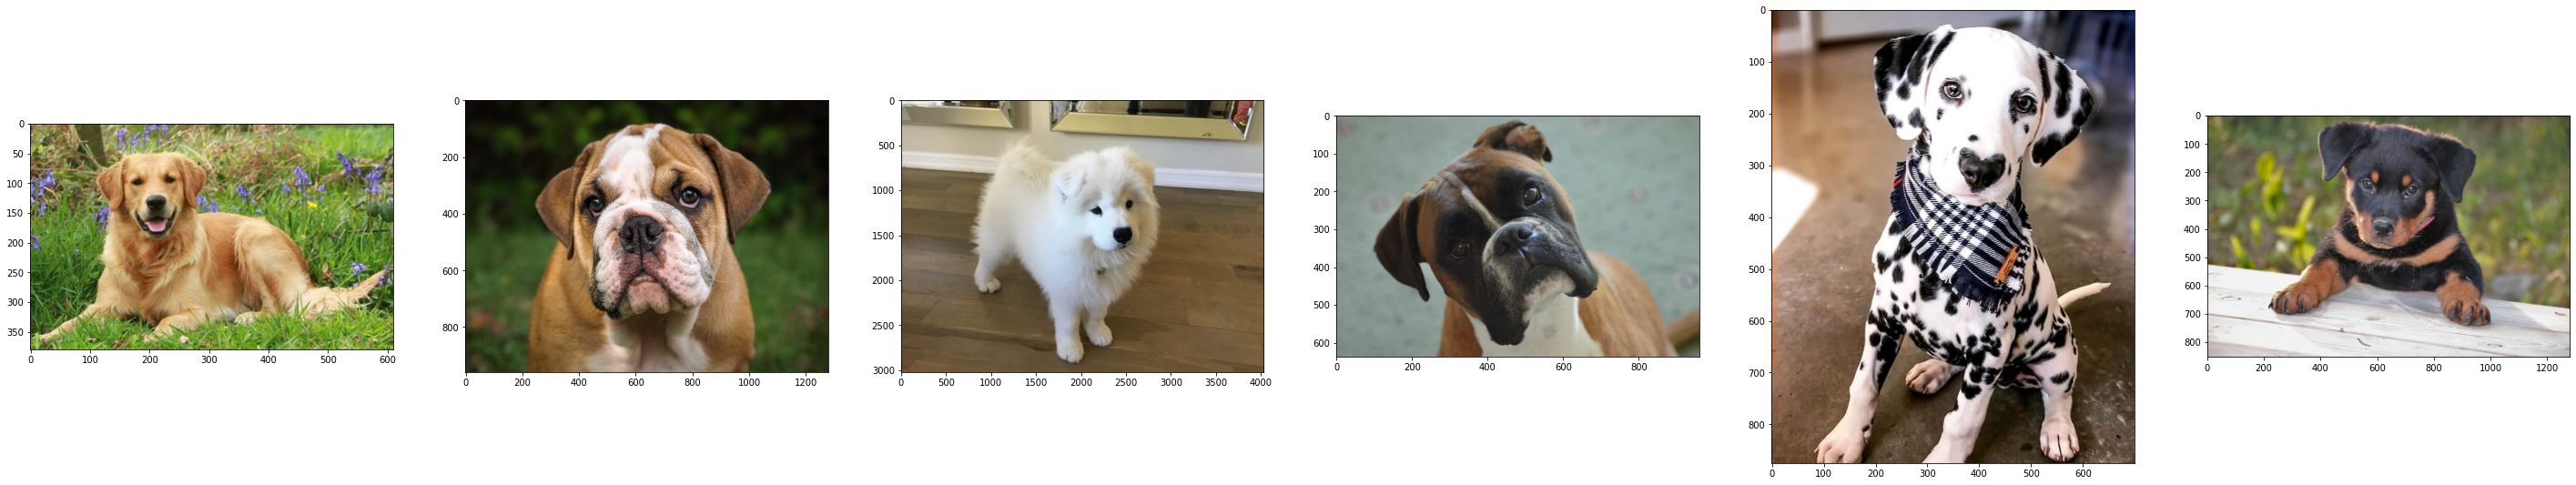

In [0]:
inference(model_list, dogs_batch, labels)

fig,axes = plt.subplots(ncols = 6, figsize=(50,50))
for i in range(6):
    axes[i].imshow(dogs[i])

For the classification of photographs that depict dogs, different breeds were selected.

*   Resnet: This network correctly identifies all pictures as depictions of dogs. The only photo that is not correctly classified as far as the breed is concerned is the second one. Nevertheless, the top five predictions of the model are dog breeds. 
*   Inception: Inception predicts correctly and with great confidence all photographs apart from the second one. In that image a large probability is assigned to one breed with significantly lower probabilities of classifying the image to another "close" breed.
*   GoogleNet: The network correctly classifies all images with high confidence apart from the second one.
*   AlexNet: The AlexNet model correctly classifies all images, apart from the second one that is incorrectly classified as a boxer with high confidence given the similarity of that breed with the depicted bulldog. 
*   Vgg16: Same correct classification here apart from the second image that is assigned with the labels of the breeds bull mastiff and boxer with close probabilities. 

resnet
['jellyfish', 'sea_anemone', 'flatworm', 'coral_reef', 'sea_slug']
['98.79%', '0.76%', '0.10%', '0.06%', '0.03%']
['jellyfish', 'sea_anemone', 'analog_clock', 'volcano', 'magnetic_compass']
['97.56%', '0.89%', '0.40%', '0.15%', '0.11%']
['jellyfish', 'nematode', 'nail', 'sea_snake', 'parachute']
['99.92%', '0.04%', '0.01%', '0.00%', '0.00%']
['jellyfish', 'sea_anemone', 'volcano', 'nematode', 'coral_reef']
['99.88%', '0.05%', '0.01%', '0.00%', '0.00%']
['jellyfish', 'electric_ray', 'chambered_nautilus', 'sea_anemone', 'sea_slug']
['99.79%', '0.07%', '0.06%', '0.02%', '0.01%']
['jellyfish', 'sea_anemone', 'Petri_dish', 'coral_reef', 'electric_ray']
['100.00%', '0.00%', '0.00%', '0.00%', '0.00%']
inception
['jellyfish', 'mushroom', 'electric_fan', 'sea_anemone', 'isopod']
['82.10%', '10.24%', '2.27%', '0.83%', '0.47%']
['electric_fan', 'jellyfish', 'hair_slide', 'hook', 'bearskin']
['49.44%', '22.60%', '16.18%', '0.90%', '0.83%']
['jellyfish', 'basketball', 'candle', 'maraca', 'ko

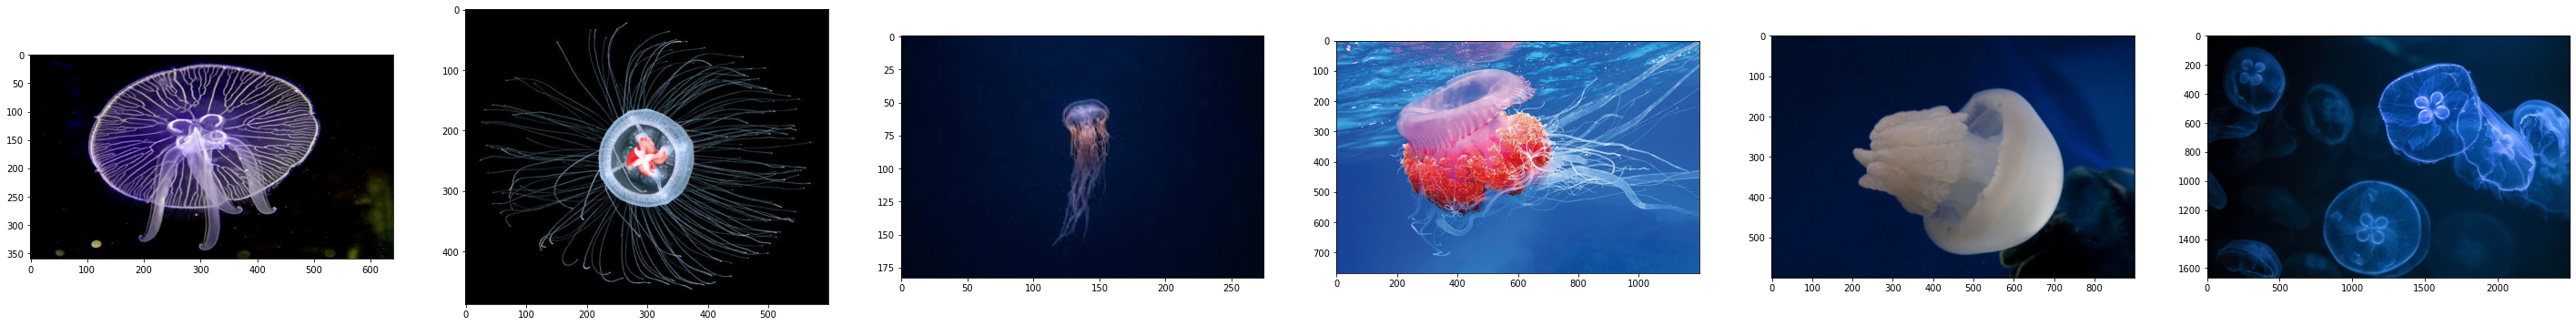

In [0]:
inference(model_list, jellyfish_batch, labels)

fig,axes = plt.subplots(ncols = 6, figsize=(50,50))
for i in range(6):
    axes[i].imshow(jellyfish[i])

The selected photographs depict different species of jellyfish from different point of views. 
*   Resnet: Resnet identifies all jellyfish images with high accuracy. 
*   Inception: This network correctly classifies most of the pictures with high probabilities. Nevertheless, the second and fifth images "confuse" the network to an extent. The second image is classified with the highest probability as an electric fan, while the fifth despite being classified correctly as jellyfish, is classified second most probable as conch.
*   GoogleNet: GoogleNet predicts correctly the category of all images but with relatively low confidence in most cases.
*   AlexNet:  Apart from the second image that is assigned with the probability 0.0449 of depicting jellyfish, the rest of the images are correctly classified with low confidence. Exceptions are the last two images that are correctly classified with high confidence.
*   Vgg16: Vgg16 classifies with high confidence the images as jellyfish. Only the second image seems confusing to the network, which assigns a viable probability to the depiction of a sea anemone.

From the above, the ResNet and Inception v3 networks have achieved the identification of qualitative characteristics of the depicted categories. Therefore, they classify with high confidence all the images that they are presented with. It is obvious that these networks have evolved to face problems that the previous networks have faced, such as the problem of the vanishing gradient and the represenation bottleneck. Moreover, the identification of high level feautres is due to their depth, since Resnet consists of 152 layers and Inception v3 48 layers, in comparison to Alexnet (8 layers), Vgg16 (16 layers) and GoogleNet (22 layers).

### Alternative data feed

Here an alternative method has been created in order to feed the pretrained models with the selected images. A subclass of the abstract class torch.utils.data.Dataset has been created. The custom dataset inherits the methods of the abstract class, that are then overriden. The image preprocessing has remained the same with the exception of providing the option as to whether the preprocessing will take place or not.

In [0]:
class imagesDataset(Dataset):
    def __init__(self, path, transform=False):
        self.transform = transform
        self.path = path
        self.transforms = transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize(
            mean = [0.485, 0.456, 0.406],
            std = [0.229, 0.224, 0.225])
         ])
        self.images = [Image.open(filename) for filename in glob.glob(path+'/*.jpg')]
        if self.transform:
            self.images = list(map(self.transforms, self.images))

    def __len__(self):
        return len(self.images)

    def __getitem__(self,index):
        return self.images[index].cuda()

In the \___getitem\___ method each of the pre-trained CNN's is fed with one image at a time.

resnet
['tusker', 'African_elephant', 'Indian_elephant', 'hartebeest', 'triceratops']
['54.94%', '44.87%', '0.19%', '0.00%', '0.00%']
inception
['African_elephant', 'tusker', 'Indian_elephant', 'combination_lock', 'ocarina']
['94.38%', '5.62%', '0.00%', '0.00%', '0.00%']
googlenet
['African_elephant', 'tusker', 'Indian_elephant', 'cardigan', 'chain_mail']
['61.81%', '29.57%', '0.75%', '0.25%', '0.14%']
alexnet
['African_elephant', 'tusker', 'Indian_elephant', 'bighorn', 'ram']
['54.07%', '44.32%', '1.61%', '0.00%', '0.00%']
vgg16
['African_elephant', 'tusker', 'Indian_elephant', 'triceratops', 'cardigan']
['73.00%', '25.09%', '1.91%', '0.00%', '0.00%']
resnet
['Indian_elephant', 'tusker', 'African_elephant', 'triceratops', 'hippopotamus']
['89.31%', '9.88%', '0.71%', '0.02%', '0.02%']
inception
['Indian_elephant', 'tusker', 'African_elephant', 'chain_mail', 'hamper']
['92.97%', '7.03%', '0.00%', '0.00%', '0.00%']
googlenet
['Indian_elephant', 'tusker', 'African_elephant', 'Komodo_drago

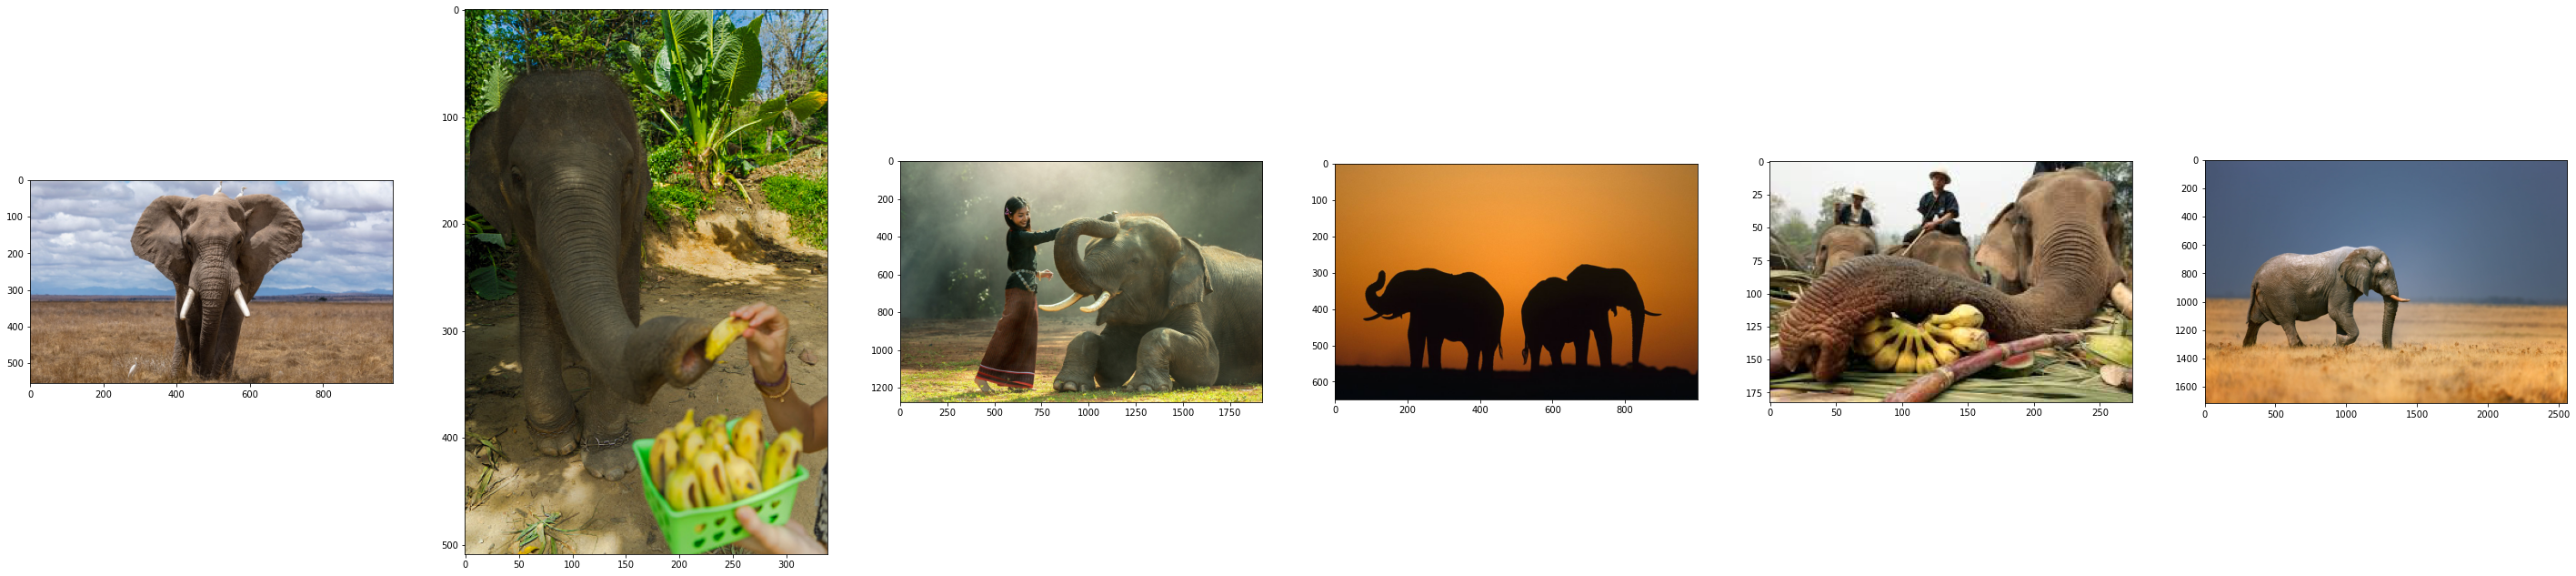

In [0]:
elephant_ds = imagesDataset('elephants', transform=True)
for elephant_img in elephant_ds:
    inference(model_list, elephant_img.reshape(1,3,224,224), labels)

fig,axes = plt.subplots(ncols = 6, figsize=(50,50))
for i in range(6):
    axes[i].imshow(elephants[i])